# Access the database
* 1.368.235.072 Commits
*    32.411.734 Users
*   125.486.232 Projects

In [2]:
import numpy as numpy
import matplotlib.pyplot as pyplot

In [10]:
%load_ext autoreload
%aimport dbUtils
%autoreload 1

In [2]:
dbUtils.runQuery('''
    select column_name, data_type from information_schema.columns
    where table_name = 'commits';
''')

Time used: 0.3947935104370117


,column_name,data_type
0,id,integer
1,author_id,integer
2,committer_id,integer
3,project_id,integer
4,created_at,timestamp without time zone
5,sha,character varying


In [7]:
display(dbUtils.lastResult)

,column_name,data_type
0,id,integer
1,author_id,integer
2,committer_id,integer
3,project_id,integer
4,created_at,timestamp without time zone
5,sha,character varying


___

### Delete all the views (caution!)

In [46]:
dbUtils.runQuery('''
   DROP MATERIALIZED VIEW lb_sample_commits CASCADE; 
   DROP MATERIALIZED VIEW lb_sample_commits_all; 
   DROP MATERIALIZED VIEW lb_sample_projects;
   DROP MATERIALIZED VIEW lb_sample_users;
   SELECT table_name FROM INFORMATION_SCHEMA.views WHERE table_schema = ANY (current_schemas(false));
''')

Time used: 0.3165092468261719


,table_name


---

### Get sample users: 
VIEW crm20.lb_sample_users

In [47]:
dbUtils.runQuery('''
    CREATE TABLE crm20.lb_sample_users AS
    (SELECT id FROM ght.users WHERE MOD(id, 1221) = 5 AND type = 'USR');
    SELECT * FROM crm20.lb_sample_users
''')

Time used: 15.170296669006348


,id
0,40898621
1,40899842
2,40901063
3,40902284
4,40903505
...,...
25596,40890074
25597,40892516
25598,40891295
25599,40896179


### Get projects the sample users worked on:
VIEW crm20.lb_sample_projects

In [48]:
dbUtils.runQuery('''
    CREATE MATERIALIZED VIEW crm20.lb_sample_projects AS
    (SELECT DISTINCT repo_id
    FROM lb_sample_users, ght.project_members 
    WHERE id = user_id);
    SELECT * FROM crm20.lb_sample_projects
''')

Time used: 4.857574939727783


,repo_id
0,948
1,1282
2,1467
3,3452
4,3465
...,...
9746,137381992
9747,137465545
9748,137467578
9749,137500216


### Commits in that repos

VIEW crm20.lb_sample_commits_all

In [49]:
dbUtils.runQuery('''
    CREATE MATERIALIZED VIEW crm20.lb_sample_commits_all AS
    (SELECT commit_id 
    FROM ght.project_commits, crm20.lb_sample_projects
    WHERE project_id = repo_id );
    SELECT * FROM crm20.lb_sample_commits_all
''')

Time used: 323.5867714881897


,commit_id
0,16634
1,16638
2,16643
3,16649
4,16654
...,...
2362837,1414955140
2362838,1414955844
2362839,1415274427
2362840,1415291770


### Commits in that repos from sample users

VIEW crm20.lb_sample_commits

In [51]:

dbUtils.runQuery('''
    DROP MATERIALIZED VIEW IF EXISTS crm20.lb_sample_commits;
    
    CREATE MATERIALIZED VIEW crm20.lb_sample_commits AS
    (SELECT commit_id, sha, author_id, created_at 
    FROM crm20.lb_sample_commits_all, ght.commits
    WHERE commit_id = id AND author_id IN (SELECT * FROM crm20.lb_sample_users));
    
    SELECT * FROM crm20.lb_sample_commits
''')

Time used: 3069.5385735034943


,commit_id,sha,author_id,created_at
0,185906520,0d1d41ae4c9f21bca17da2c22e3993e879c0287e,5496947,2014-12-04 16:17:25
1,185985475,3c5c3fc622c5b40ba6a6e8a5e64a84c2f5bf9484,5496947,2014-12-05 23:58:37
2,186113980,720b7b9144bedd22def6cfed36bd83e2d8a441da,5496947,2014-12-08 14:34:27
3,186340109,c3dd8335cee7c652763caf17e44682847a3c300b,5496947,2014-12-09 21:36:26
4,191681100,3984edbfee600deefc9f993ebbc1990ab115d50d,5496947,2014-12-14 20:06:24
...,...,...,...,...
105408,1413960421,35da62fb9118772950f82e23c904dd01c61cb766,50228282,2019-05-30 20:49:58
105409,1413988414,64c35463dc7465096c7bdc294bbf9380c5b661f6,50228282,2019-05-30 21:11:59
105410,1413993902,e265ab06832bbabf97d5d16d9b6635b6608c68e9,50228282,2019-05-30 21:16:57
105411,1414008778,7b0f97ea91c9f1f89cf44e6eb1f9bc342cd3cda9,50228282,2019-05-30 21:30:27


## Alternative Commit Data

In [ ]:
# TODO add project?
dbUtils.runQuery('''
    CREATE MATERIALIZED VIEW crm20.lb_changes AS
        (SELECT commit_id, lb_sample_commits.sha, SUM(changes) AS loc, SUBSTRING(name from '\.([^\.]*)$') AS language
        FROM crm20.lb_sample_commits, ght.raw_patches
        WHERE lb_sample_commits.sha = raw_patches.sha
        GROUP BY commit_id, lb_sample_commits.sha, language);
    SELECT * FROM crm20.lb_changes
''')

In [32]:
dbUtils.runQuery('''
    SELECT * FROM crm20.lb_changes
''')

Time used: 0.4778120517730713


,commit_id,sha,loc,language
0,21643,b53eb0b28c65943f9af14ed79050233ae108f113,0,mo
1,21643,b53eb0b28c65943f9af14ed79050233ae108f113,612,po
2,108989,e9958f75ee115e522383d4a65c43fa2435339540,22,js
3,108989,e9958f75ee115e522383d4a65c43fa2435339540,9,rdoc
4,120368,440bff9a521720e3bbbd24a0c2194494a59c7bd9,78,coffee
...,...,...,...,...
206637,1415318746,aef00bfa756bb75ab1215ba740668acb079b194e,9,yml
206638,1415343306,c6b582fc50eeac85fa004813fd7607c851de7708,2,txt
206639,1415343310,eadb053d440a6bd78d6b723e50c5f5df6c5842bf,1,h
206640,1415343310,eadb053d440a6bd78d6b723e50c5f5df6c5842bf,2,hh


In [29]:
dbUtils.runQuery('''
    CREATE OR REPLACE VIEW crm20.lb_changes_agg AS
        (SELECT commit_id, sha, ARRAY_AGG(loc) AS locs, ARRAY_AGG(language) AS languages
        FROM crm20.lb_changes
        GROUP BY commit_id, sha);
    SELECT commit_id, locs[ARRAY_POSITION(languages, 'java')]
    FROM crm20.lb_changes_agg
    WHERE 'java' = ANY(languages)
''')

Time used: 0.2812795639038086


,commit_id,locs
0,197017,1
1,197018,6
2,197019,1
3,197020,49
4,197021,39
...,...,...
9121,1412522419,2
9122,1413880842,51
9123,1413880874,79
9124,1413892402,2


In [38]:
dbUtils.runQuery('''
    SELECT author_id, language, SUM(loc) AS loc, MIN(created_at) as first_written
    FROM crm20.lb_sample_commits, crm20.lb_changes
    WHERE lb_sample_commits.commit_id = lb_changes.commit_id
    GROUP BY author_id, language
''')

Time used: 0.30278682708740234


,author_id,language,loc,first_written
0,5,2,6.0,2014-04-07 12:09:46
1,5,au,2.0,2011-03-13 16:26:02
2,5,cn,2.0,2011-03-13 16:26:02
3,5,com/bluele/slack/LICENSE,21.0,2018-11-16 11:26:22
4,5,com/google/go-querystring/LICENSE,54.0,2017-02-09 10:59:19
...,...,...,...,...
29142,51632432,txt,79.0,2019-05-31 10:23:24
29143,51632432,yaml,2342.0,2019-05-31 10:23:24
29144,51632432,yml,0.0,2019-05-31 11:24:51
29145,51632432,None,0.0,2019-05-31 11:24:51


## Which author did which file endings?

In [ ]:
dbUtils.runQuery('''

    CREATE MATERIALIZED VIEW crm20.lb_languages AS
        (SELECT author_id, SUBSTRING(name from '\.([^\.]*)$') AS language, SUM(changes) AS loc, MIN(created_at) as first_written
        FROM crm20.lb_sample_commits, ght.raw_patches
        WHERE lb_sample_commits.sha = raw_patches.sha
        GROUP BY author_id, language);
        
    SELECT * FROM crm20.lb_languages
''')

In [58]:
dbUtils.runQuery('''
    DROP MATERIALIZED VIEW IF EXISTS crm20.lb_file_endings;
    SELECT * FROM crm20.lb_languages
''')

Time used: 0.06693172454833984


,author_id,language,loc,first_written
0,5,2,6,2014-04-07 12:09:46
1,5,au,2,2011-03-13 16:26:02
2,5,cn,2,2011-03-13 16:26:02
3,5,com/bluele/slack/LICENSE,21,2018-11-16 11:26:22
4,5,com/google/go-querystring/LICENSE,54,2017-02-09 10:59:19
...,...,...,...,...
29142,51632432,txt,79,2019-05-31 10:23:24
29143,51632432,yaml,2342,2019-05-31 10:23:24
29144,51632432,yml,0,2019-05-31 11:24:51
29145,51632432,None,0,2019-05-31 11:24:51


## Java users with more than 3000 lines

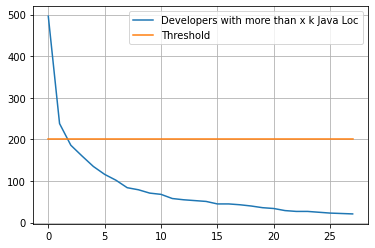

In [60]:
x = []
y = []
y2 = []
for i in range(28):
    dbUtils.runQuery('''
        SELECT COUNT(*) AS num
        FROM crm20.lb_languages
        WHERE language = 'java' AND loc >= '''+str(i * 1000)+'''
    ''', True)
    x.append(i)
    y.append(lastResult['num'][0])
    y2.append(200)
    
pyplot.grid()
pyplot.plot(x, y)
pyplot.plot(x, y2)
pyplot.legend(['Developers with more than x k Java Loc', 'Threshold'])

In [61]:
dbUtils.runQuery('''
    DROP VIEW IF EXISTS crm20.lb_java_users;
    
    CREATE VIEW crm20.lb_java_users AS
        (SELECT *
        FROM crm20.lb_languages
        WHERE language = 'java' AND loc > 3000);
        
    SELECT * FROM crm20.lb_java_users
''')

Time used: 0.08679819107055664


,author_id,language,loc,first_written
0,6110,java,4714,2012-03-13 20:27:43
1,10994,java,6323,2012-07-25 15:45:22
2,17099,java,18085,2011-12-10 23:27:01
3,26867,java,8111,2012-11-04 10:46:08
4,30530,java,24579,2014-07-11 15:04:53
...,...,...,...,...
155,46487138,java,14771,2018-10-27 07:23:46
156,46937687,java,19358,2019-02-03 15:21:07
157,47835122,java,5493,2018-12-11 14:12:33
158,49120835,java,3234,2019-02-24 20:10:41


## Number of developers per language (or file ending, more precisely)
Note: As there is no filtering for linecount > 0, this numbery may differ from the other ones

In [62]:
dbUtils.runQuery('''
    SELECT language, COUNT(author_id) AS devs
    FROM crm20.lb_languages
    GROUP BY language
    HAVING 
        language <> 'png' 
        AND language <> 'md' 
        AND language <> 'None' 
        AND language <> 'txt' 
        AND language <> 'gitignore' 
        AND language <> 'html' 
        AND language <> 'css'
        AND language <> 'scss'
        AND language <> 'xml'
        AND language <> 'json'
        AND language <> 'jpg'
        AND language <> 'yml'
        AND language <> 'svg'
        AND language <> 'ttf'
        AND language <> 'properties'
        AND language <> 'gif'
        AND language <> 'ico'
        AND language <> 'lock'
        AND language <> 'pdf'
    ORDER BY devs DESC
    LIMIT 30
''')

Time used: 0.01645684242248535


,language,devs
0,js,724
1,java,496
2,py,355
3,php,260
4,h,224
5,sh,208
6,cs,189
7,woff,180
8,eot,172
9,jar,170


## Number of Java Devs with secondary language
(1000 LoC in other language and)

In [79]:
dbUtils.runQuery('''
        SELECT lb_java_users.author_id, lb_java_users.loc AS javaLoC,  lb_java_users.first_written as javaStart, ARRAY_AGG(lb_languages.language) AS secondary_languages, ARRAY_AGG(lb_languages.loc) AS secLoC, ARRAY_AGG(lb_languages.first_written) as secStart
        FROM crm20.lb_java_users, crm20.lb_languages
        WHERE lb_java_users.author_id = lb_languages.author_id 
        AND (lb_languages.language = 'py' OR lb_languages.language = 'js') AND lb_languages.loc > 1000
        GROUP BY lb_java_users.author_id, lb_java_users.loc, lb_java_users.first_written
        HAVING lb_java_users.loc / 2 > ALL(ARRAY_AGG(lb_languages.loc))
        AND lb_java_users.first_written < ALL(ARRAY_AGG(lb_languages.first_written))
''')

Time used: 0.007347583770751953


,author_id,javaloc,javastart,secondary_languages,secloc,secstart
0,69602,149818,2012-07-06 20:21:47,[js],[14102],[2012-11-16 18:22:57]
1,1275950,79795,2014-01-21 13:25:31,[py],[3020],[2014-03-29 16:39:49]
2,1979246,34247,2013-06-06 05:28:21,[js],[7991],[2013-06-10 07:17:46]
3,2200247,18317,2014-09-10 21:07:58,[py],[2234],[2014-10-09 18:11:46]
4,2725277,31015,2014-05-28 08:19:28,[js],[9449],[2014-06-07 08:30:32]
5,3242981,20263,2014-01-30 16:13:29,[js],[2296],[2014-11-08 16:28:25]
6,4908425,13493,2014-08-15 04:49:30,[js],[5306],[2015-09-27 06:27:28]
7,5080586,42824,2014-08-25 10:38:05,[js],[18614],[2014-09-16 14:15:56]
8,9297920,17813,2015-09-22 00:45:02,[py],[1397],[2018-04-23 12:41:53]
9,10328444,48735,2016-03-09 21:08:22,[py],[4419],[2016-09-08 14:13:20]


## Statistics about user languages:

### How many users write n times as much Java code as their secondary language (but still 1000 LoC in Secondary!)

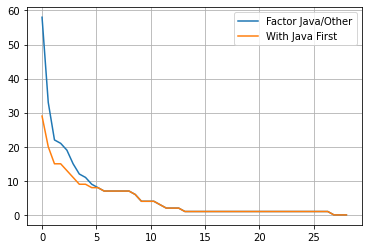

In [81]:
x = []
y = []

x2 = []
y2 = []
for i in numpy.linspace(0, 28, 50):
    dbUtils.runQuery('''
        SELECT '''+str(i)+''' AS factor, COUNT(author_id) AS devs FROM
            (SELECT lb_java_users.author_id, lb_java_users.loc AS javaLoC, ARRAY_AGG(lb_languages.language) AS secondary_languages, ARRAY_AGG(lb_languages.loc) AS secLoC
            FROM crm20.lb_java_users, crm20.lb_languages
            WHERE lb_java_users.author_id = lb_languages.author_id 
            AND (lb_languages.language = 'py' OR lb_languages.language = 'js') AND lb_languages.loc > 1000
            GROUP BY lb_java_users.author_id, lb_java_users.loc
            HAVING lb_java_users.loc >= ALL(ARRAY_AGG(lb_languages.loc * '''+str(i)+'''))) AS x
    ''', True)
    x.append(lastResult['factor'][0])
    y.append(lastResult['devs'][0])
    
for i in numpy.linspace(0, 28, 50):
    dbUtils.runQuery('''
        SELECT '''+str(i)+''' AS factor, COUNT(author_id) AS devs FROM
            (SELECT lb_java_users.author_id, lb_java_users.loc AS javaLoC, ARRAY_AGG(lb_languages.language) AS secondary_languages, ARRAY_AGG(lb_languages.loc) AS secLoC
            FROM crm20.lb_java_users, crm20.lb_languages
            WHERE lb_java_users.author_id = lb_languages.author_id 
            AND (lb_languages.language = 'py' OR lb_languages.language = 'js') AND lb_languages.loc > 1000
            GROUP BY lb_java_users.author_id, lb_java_users.loc, lb_java_users.first_written
            HAVING lb_java_users.loc >= ALL(ARRAY_AGG(lb_languages.loc * '''+str(i)+'''))
            AND lb_java_users.first_written < ALL(ARRAY_AGG(lb_languages.first_written))) AS x
    ''', True)
    x2.append(lastResult['factor'][0])
    y2.append(lastResult['devs'][0])
    
pyplot.grid()
pyplot.plot(x, y)
pyplot.plot(x2, y2)
pyplot.legend(['Factor Java/Other', 'With Java First'])

### Which secondary languages are there?

In [41]:
dbUtils.runQuery('''
    SELECT secondary_languages, COUNT(author_id)
    FROM
        (SELECT lb_java_users.author_id, ARRAY_AGG(lb_languages.language) AS secondary_languages
        FROM crm20.lb_java_users, crm20.lb_languages
        WHERE lb_java_users.author_id = lb_languages.author_id 
        AND (lb_languages.language = 'py' OR lb_languages.language = 'js') AND lb_languages.loc > 1000
        GROUP BY lb_java_users.author_id) AS secondaries
    GROUP BY secondary_languages
''')

Time used: 0.030758142471313477


,secondary_languages,count
0,[js],47
1,"[js, py]",3
2,[py],8


---
# Enriched Commits

In [6]:
dbUtils.runQuery('''
    CREATE VIEW crm20.lb_java_user_commits AS
        (SELECT lb_sample_commits.*
        FROM crm20.lb_sample_commits, crm20.lb_java_users
        WHERE lb_sample_commits.author_id = lb_java_users.author_id);
        
    SELECT * FROM crm20.lb_java_user_commits
''')

Time used: 0.9031598567962646


,commit_id,sha,author_id
0,142815636,ca18f21078dfd5a852cb41fcbd1fa366d4084dab,10994
1,142815635,76870632b1bf79f25de5c5a63e394f8979e5179f,10994
2,142815631,7d952ba8dab23b2d95f8dc43b00db8888ee4bb50,10994
3,142815630,d483ba21fb4ee87df9fe660ad43e365645387a75,10994
4,142815629,8308177be05642c71b2aa927b280036f4e7b5ea3,10994
...,...,...,...
17521,1112618353,28b4705d3c28c4819ed093a5d11e1232000bd790,45333293
17522,1112618352,42c702ca6073292d3b782ddd24e8b174456fb638,45333293
17523,1112618348,83dc1957f1a2aed5737507e5e15c6b07816ebf53,45333293
17524,1112618330,21c3c59e9594c31391a926dbf2d9b3b69d429ce0,45333293


In [ ]:
dbUtils.runQuery('''
    CREATE VIEW crm20.lb_
''')

In [ ]:
dbUtils.runQuery('''
    DROP MATERIALIZED VIEW crm20.lb_enriched_commits;

    CREATE MATERIALIZED VIEW crm20.lb_enriched_commits AS
        (SELECT lb_sample_commits.*, created_at, SUBSTRING(raw_patches.name from '\.([^\.]*)$') AS language, changes
        FROM crm20.lb_sample_commits, ght.commits, crm20.lb_java_users, ght.raw_patches
        WHERE commit_id = commits.id
        AND lb_sample_commits.author_id = lb_java_users.author_id
        AND raw_patches.sha = lb_sample_commits.sha
        AND (
            SUBSTRING(raw_patches.name from '\.([^\.]*)$') = 'py' 
            OR SUBSTRING(raw_patches.name from '\.([^\.]*)$') = 'js' 
            OR SUBSTRING(raw_patches.name from '\.([^\.]*)$') = 'java')
        );
    
    SELECT * FROM crm20.lb_enriched_commits
''')

In [8]:
lastResult

,commit_id,sha,author_id,created_at,file_ending,changes
0,393385028,7f2aac527e07e943f6be85a9b7fb1186c3b45383,2985350,2016-02-21 06:33:24,java,6
1,393385028,7f2aac527e07e943f6be85a9b7fb1186c3b45383,2985350,2016-02-21 06:33:24,java,42
2,393385028,7f2aac527e07e943f6be85a9b7fb1186c3b45383,2985350,2016-02-21 06:33:24,java,19
3,393388373,9e9dc4ca308c1919161837a31b181bbd2c12810c,2985350,2016-02-21 06:47:10,java,2
4,393388373,9e9dc4ca308c1919161837a31b181bbd2c12810c,2985350,2016-02-21 06:47:10,java,2
5,393388377,3d39255cdff2064f43af9e9dc10d1b259bd77906,2985350,2016-02-21 06:47:45,java,25
6,393388377,3d39255cdff2064f43af9e9dc10d1b259bd77906,2985350,2016-02-21 06:47:45,java,25
7,393388377,3d39255cdff2064f43af9e9dc10d1b259bd77906,2985350,2016-02-21 06:47:45,java,37
8,393388377,3d39255cdff2064f43af9e9dc10d1b259bd77906,2985350,2016-02-21 06:47:45,java,16
9,393388377,3d39255cdff2064f43af9e9dc10d1b259bd77906,2985350,2016-02-21 06:47:45,java,7


In [ ]:
lastTimeToRun